In [24]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal

In [25]:
#PARAMETERS
TIMEFRAME = "12h"
PAIR = "ETHUSDT"
DATA_WINDOW_LENGTH = 1000
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

In [26]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")

In [27]:
config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)
# logging.info(futures_client.continuous_klines("BTCUSDT", 'PERPETUAL', '15m', limit=100));
klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, limit=DATA_WINDOW_LENGTH);

2022-10-15 17:46:28.265 UTC DEBUG binance.api: url: https://fapi.binance.com/fapi/v1/continuousKlines
2022-10-15 17:46:28.267 UTC DEBUG urllib3.connectionpool: Starting new HTTPS connection (1): fapi.binance.com:443
2022-10-15 17:46:28.628 UTC DEBUG urllib3.connectionpool: https://fapi.binance.com:443 "GET /fapi/v1/continuousKlines?pair=ETHUSDT&contractType=PERPETUAL&interval=12h&limit=1000 HTTP/1.1" 200 None
2022-10-15 17:46:28.649 UTC DEBUG binance.api: raw response from server:[[1622678400000,"2707.03","2892.23","2662.00","2808.22","1917220.466",1622721599999,"5367848815.72138",2091786,"951620.221","2664258015.20943","0"],[1622721600000,"2808.26","2873.47","2762.61","2858.34","1643892.769",1622764799999,"4619780245.72200",1869383,"809452.921","2275118315.11252","0"],[1622764800000,"2858.34","2861.53","2585.00","2624.99","2459426.288",1622807999999,"6590949875.25149",2515007,"1204628.049","3226700993.05490","0"],[1622808000000,"2625.00","2738.60","2540.61","2689.21","1884400.594",162

In [28]:
def process_klines(klines):

    df = pd.DataFrame(klines)
    df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
    df['trades'] = pd.to_numeric(df['trades'])
    df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
    df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
    df['ignore'] = pd.to_numeric(df['ignore'])
    df.drop(['ignore'], axis=1, inplace=True)
    return df

In [29]:
df = process_klines(klines)

In [30]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
mean_std = closes_std.mean()
closes_mean.mean(), mean_std

(2656.5532985397917, 72.58966037461977)

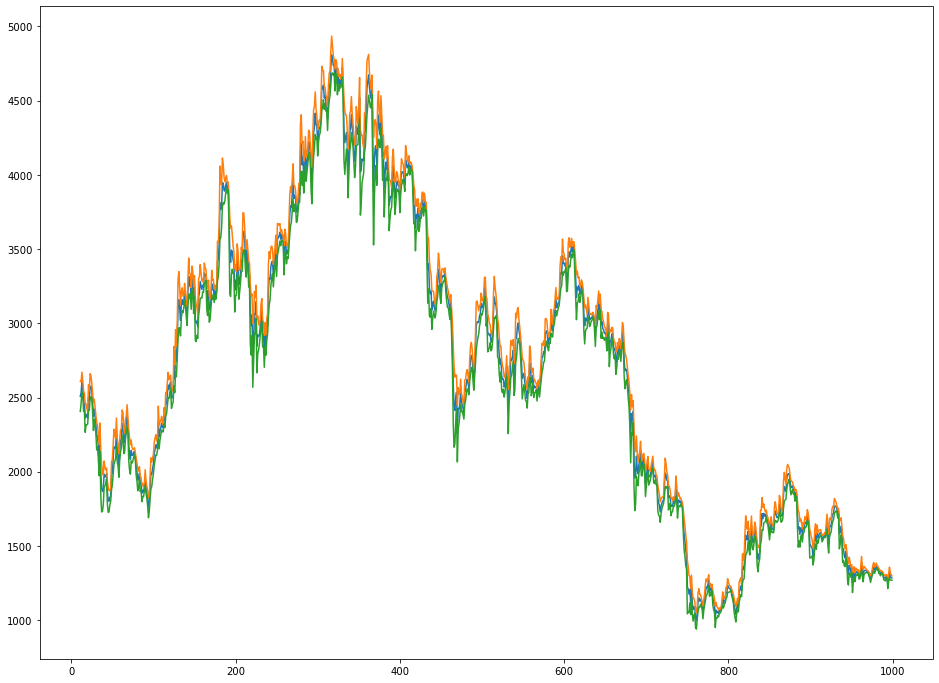

In [31]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(closes_mean)
ax.plot(closes_mean + closes_std)
ax.plot(closes_mean - closes_std)

In [32]:
peak_indexes = signal.argrelextrema(df.close.values, np.greater)
peak_indexes = peak_indexes[0]

valley_indexes = signal.argrelextrema(df.close.values, np.less)
valley_indexes = valley_indexes[0]

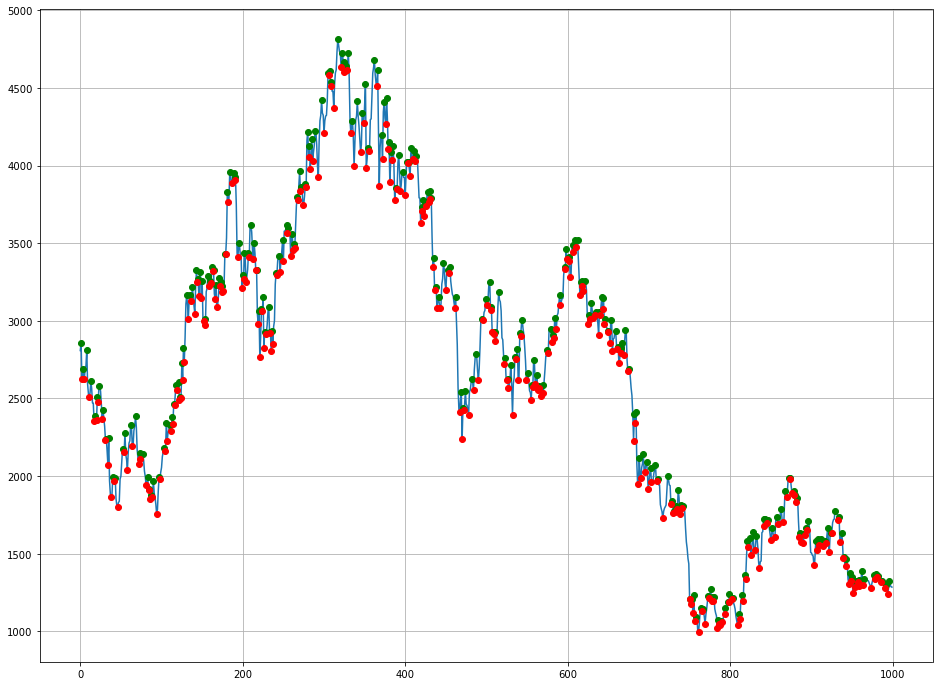

In [33]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [34]:
(-1)*df.close.values

array([-2808.22, -2858.34, -2624.99, -2689.21, -2640.25, -2627.45,
       -2690.5 , -2711.4 , -2812.61, -2592.96, -2531.57, -2506.19,
       -2534.44, -2610.2 , -2565.25, -2471.11, -2468.92, -2354.25,
       -2388.14, -2370.59, -2362.08, -2508.71, -2478.46, -2579.82,
       -2576.96, -2544.17, -2460.65, -2366.84, -2424.43, -2372.51,
       -2318.88, -2231.68, -2240.15, -2163.36, -2072.59, -2242.7 ,
       -1969.02, -1884.77, -1866.03, -1878.46, -1990.38, -1966.51,
       -1964.99, -1989.5 , -1852.84, -1808.  , -1800.4 , -1828.88,
       -1837.58, -1980.83, -1998.86, -2083.56, -2174.03, -2165.15,
       -2155.64, -2275.  , -2137.74, -2105.24, -2038.  , -2152.64,
       -2212.5 , -2226.63, -2329.61, -2321.95, -2194.58, -2195.38,
       -2292.51, -2322.04, -2383.6 , -2314.65, -2168.3 , -2114.88,
       -2080.19, -2147.53, -2109.35, -2111.14, -2128.86, -2140.27,
       -2100.79, -2030.85, -1996.26, -1940.32, -1947.75, -1993.82,
       -1912.84, -1919.35, -1851.68, -1876.1 , -1863.43, -1898

In [35]:

# peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
# peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
print(peak_indexes)

# valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
# valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=1.5*mean_std)
print(valley_indexes)

[  8  23  35  40  55  62  68  90 106 121 131 138 143 147 150 162 184 202
 210 225 232 249 254 270 280 285 289 297 307 317 330 341 351 362 371 374
 377 385 392 397 407 430 447 455 469 474 487 504 515 530 538 544 558 598
 612 629 642 653 659 671 684 688 693 708 723 736 755 776 799 824 828 841
 874 896 920 929 962]
[  2  17  34  38  46  58  64  86  94 107 122 133 141 146 149 154 168 199
 204 221 226 235 250 259 274 283 286 293 300 312 324 337 345 352 368 372
 376 381 387 394 400 419 439 450 467 470 478 490 511 527 532 539 555 567
 603 625 638 652 655 663 681 686 690 699 717 730 754 761 784 809 826 836
 850 890 903 922 951]


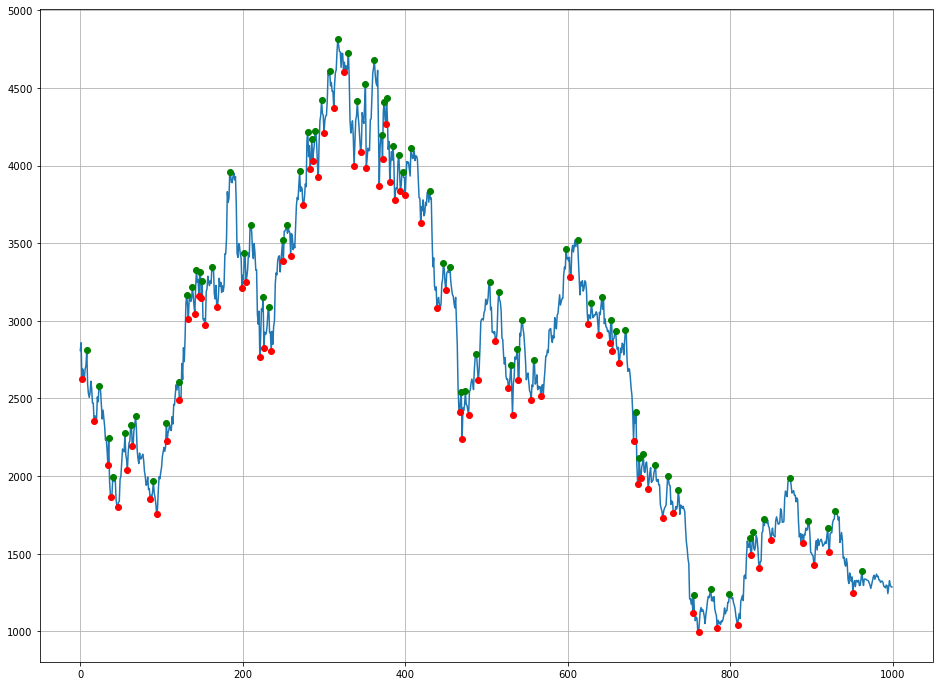

In [36]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [37]:
peak_regions = []
for peak_index in peak_indexes:
    peak_regions.append(peak_index)
    for j in range(min(max(peak_index+1, len(df.close.values) - max(peak_indexes)), 5)):
        if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index-j)
        elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index+j)        
print(len(peak_regions) - len(peak_indexes))
valley_regions = []
for valley_index in valley_indexes:
    for j in range(min(valley_index+1, len(df.close.values) - max(valley_indexes))):
        if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index-j)
        elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index+j)    
print(len(valley_regions) - len(valley_indexes))

116
219


In [38]:
len(peak_regions) - len(peak_indexes)

116

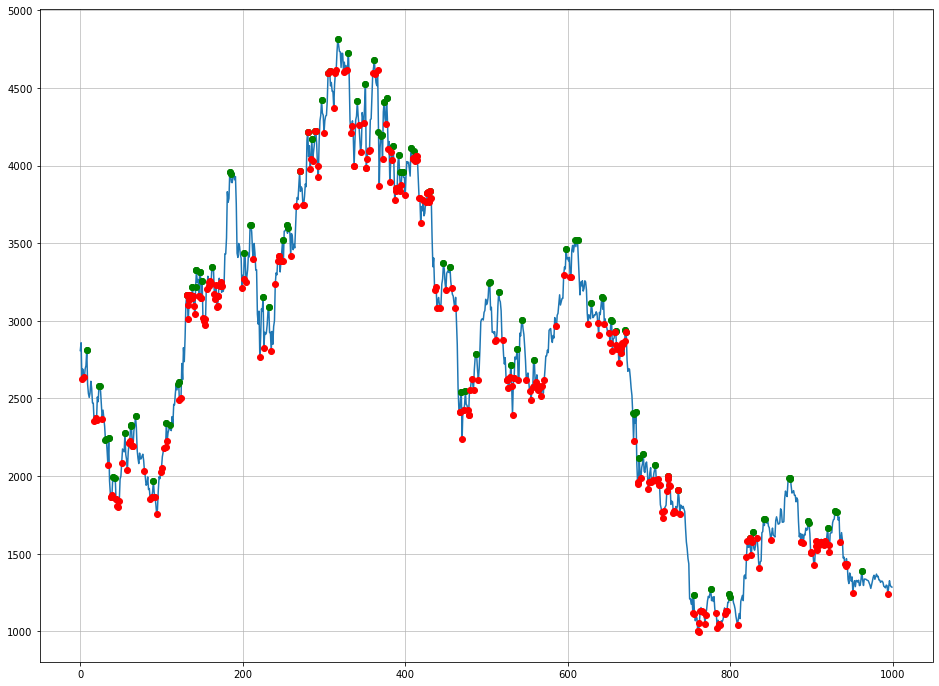

In [39]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")


In [40]:
labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
labels = pd.DataFrame(labels, columns=['labels'])
df = pd.concat([df, labels], axis=1)

print(labels[labels!=0].dropna())

     labels
2      -1.0
4      -1.0
8       1.0
17     -1.0
19     -1.0
..      ...
942    -1.0
944    -1.0
951    -1.0
962     1.0
994    -1.0

[373 rows x 1 columns]


In [41]:
df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels
0,2021-06-03 00:00:00,2707.03,2892.23,2662.00,2808.22,1917220.466,2021-06-03 11:59:59.999,5.367849e+09,2091786,951620.221,2.664258e+09,0
1,2021-06-03 12:00:00,2808.26,2873.47,2762.61,2858.34,1643892.769,2021-06-03 23:59:59.999,4.619780e+09,1869383,809452.921,2.275118e+09,0
2,2021-06-04 00:00:00,2858.34,2861.53,2585.00,2624.99,2459426.288,2021-06-04 11:59:59.999,6.590950e+09,2515007,1204628.049,3.226701e+09,-1
3,2021-06-04 12:00:00,2625.00,2738.60,2540.61,2689.21,1884400.594,2021-06-04 23:59:59.999,5.002992e+09,1999670,940468.803,2.497610e+09,0
4,2021-06-05 00:00:00,2689.41,2817.43,2622.00,2640.25,1908563.208,2021-06-05 11:59:59.999,5.232046e+09,2119191,941546.343,2.581944e+09,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-10-13 12:00:00,1242.26,1301.00,1176.00,1286.38,6877878.458,2022-10-13 23:59:59.999,8.573940e+09,3423434,3493811.165,4.360462e+09,0
996,2022-10-14 00:00:00,1286.38,1343.36,1282.74,1325.56,3283858.850,2022-10-14 11:59:59.999,4.343805e+09,1750383,1735766.103,2.295672e+09,0
997,2022-10-14 12:00:00,1325.57,1343.00,1287.01,1295.35,3887840.836,2022-10-14 23:59:59.999,5.106782e+09,2005852,1896932.942,2.492310e+09,0
998,2022-10-15 00:00:00,1295.34,1301.32,1276.02,1286.91,1516825.699,2022-10-15 11:59:59.999,1.954867e+09,829204,739616.035,9.533306e+08,0
